### Assignment 4

In [1]:
import  torch
torch.__version__

'0.4.0'

### Load and prepare data

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

try:
    with np.load('./data/parsed.npz') as data:
        train_x = data['train_x']
        validation_x = data['validation_x']
        train_y = data['train_y']
        validation_y = data['validation_y']
        test_x = data['test_x']
except:
    with np.load('./data/prediction-challenge-02-data.npz') as fh:
        data_x = fh['data_x']
        data_y = fh['data_y']
        test_x = fh['test_x']
    
    data_x = np.rollaxis(data_x, 1, 4)
    test_x = np.rollaxis(test_x, 1, 4)
    print(data_x.shape)
    train_x, validation_x, train_y, validation_y = train_test_split(data_x, data_y, test_size=.2)
    print(validation_x.shape)
    
    zip = {
        'train_x': train_x,
        'validation_x': validation_x,
        'train_y': train_y, 
        'validation_y': validation_y,
        'test_x': test_x
    }
    np.savez('./data/parsed.npz', **zip)

### Let's visualize some data

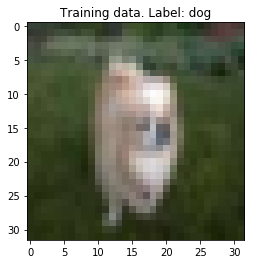

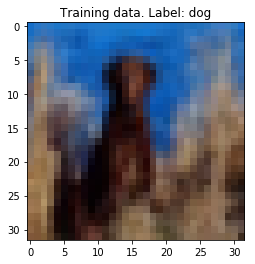

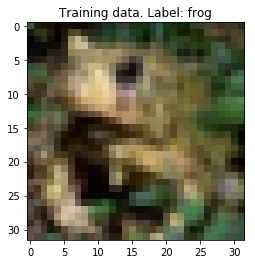

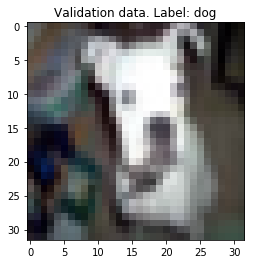

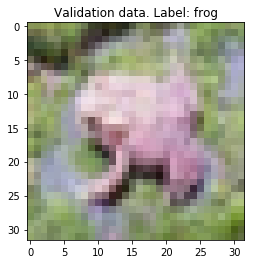

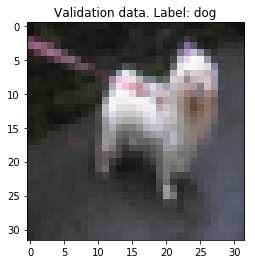

In [3]:
%matplotlib inline

labels = ['cat', 'dog', 'frog']

for i in range(3):
    plt.figure()
    plt.title('Training data. Label: {}'.format(labels[train_y[i]]))
    plt.imshow(train_x[i])
    
for i in range(3):
    plt.figure()
    plt.title('Validation data. Label: {}'.format(labels[validation_y[i]]))
    plt.imshow(validation_x[i])

### Normalize data

Here we are just calculating the mean value per channel (r,g,b) from the test data and subtracting this from each image in the dataset. 

In [4]:
per_channel_mean = np.mean(train_x, axis=0).mean(axis=0).mean(axis=0)
train_x -= per_channel_mean
validation_x -= per_channel_mean
test_x -= per_channel_mean

print('Per channel mean: {}'.format(per_channel_mean))
print('before: {}'.format(train_x[0][0][0]))
print('after: {}'.format(train_x[0][0][0] - per_channel_mean))

train_x = np.rollaxis(train_x, 3, 1)
test_x = np.rollaxis(test_x, 3, 1)
validation_x = np.rollaxis(validation_x, 3, 1)

Per channel mean: [ 0.48965949  0.45487654  0.39408451]
before: [-0.27789479 -0.19997457 -0.16663353]
after: [-0.76755428 -0.65485108 -0.56071806]


### Transform data in pytorch format

In [5]:
import torch.utils.data as data_utils

kwargs  =  {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 16}

train_dataset = data_utils.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_dataset = data_utils.TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           **kwargs)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=64,
                                          shuffle=False,
                                          **kwargs)

## Build model

We are using "transfer-learning" here.

We get a pretrained sqeezeNet model, get the first `KEEP_N_LAYERS` (for now 5) and add two further convolution layers and a linear one. We are going to only train the added layers, the layers of the pretrained squeezeNet model we are going to keep as they are for feature recognition.

In [47]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

KEEP_N_LAYERS = 6
CONV_OUT = 256

class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.pretrained = models.squeezenet1_1(pretrained=True)
        
        self.pretrained.features = nn.Sequential(
            *(self.pretrained.features[i] for i in range(KEEP_N_LAYERS)))
        
        # shape is [batch_size, 64, 7, 7] here
        conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        conv2 = nn.Conv2d(256, CONV_OUT, kernel_size=3, padding=1)
        
        self.own = nn.Sequential(
            conv1,
            nn.Dropout2d(p=0.05),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            conv2,
            nn.Dropout2d(p=0.1),
            nn.BatchNorm2d(CONV_OUT),
            nn.ReLU(inplace=True)
        )
        
        linear = nn.Linear(CONV_OUT*3*3, 3)
        self.fc = nn.Sequential(
            linear,
            nn.Softmax()
        )
        
        for param in self.pretrained.parameters():
            param.requires_grad = False
            
        
    def forward(self, x):
        for i in range(KEEP_N_LAYERS):
            x = self.pretrained.features[i](x)
        
        x = self.own(x)
        x = x.view(-1, CONV_OUT*3*3)
        x = self.fc(x)
        
        return x

In [48]:
model = convNet()

if torch.cuda.is_available():
    model.cuda()

/home/hristov/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/hristov/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [49]:
import  torch.optim as optim

optimizer = optim.Adam(model.own.parameters(), lr=0.01)

In [50]:
from torch.autograd import Variable

def train(epoch, callback, verbose=False):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        optimizer.step()
        
        callback(batch_idx, output, target)
        
        if verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [51]:
from decimal import *
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in validation_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(validation_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct.item(), len(validation_loader.dataset),
        100. * correct.item() / len(validation_loader.dataset)))
    
    return Decimal((100. * correct.item()) / (1. * len(validation_loader.dataset))), test_loss

In [52]:
def  save_accuracy(i, output, target, save_in):
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.data.view_as(pred)).cpu().sum()
    save_in.append(100. * correct / len(output))
    
def get_save_acc_in(save_in):
    return lambda x, y, z: save_accuracy(x, y, z, save_in)

In [53]:
%%time

from torch.optim.lr_scheduler import ReduceLROnPlateau

per_batch_acc = []
epoch_acc = []
val_losses = []
best_acc = 0
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=0.000001, cooldown=2)

for epoch in range(1, 50):
    train(epoch, get_save_acc_in(per_batch_acc), verbose=True)
    accuracy, val_loss = test()
    epoch_acc.append(accuracy)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    if best_acc < accuracy:
        best_acc = accuracy
        torch.save(model.state_dict(), './model_2')


/home/hristov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [64/4800 (1%)]	Loss: 1.105614
Train Epoch: 1 [128/4800 (3%)]	Loss: 1.219448
Train Epoch: 1 [192/4800 (4%)]	Loss: 1.206370
Train Epoch: 1 [256/4800 (5%)]	Loss: 1.115816
Train Epoch: 1 [320/4800 (7%)]	Loss: 1.038613
Train Epoch: 1 [384/4800 (8%)]	Loss: 1.031888
Train Epoch: 1 [448/4800 (9%)]	Loss: 1.044822
Train Epoch: 1 [512/4800 (11%)]	Loss: 0.974233
Train Epoch: 1 [576/4800 (12%)]	Loss: 1.000576
Train Epoch: 1 [640/4800 (13%)]	Loss: 0.990752
Train Epoch: 1 [704/4800 (15%)]	Loss: 0.988001
Train Epoch: 1 [768/4800 (16%)]	Loss: 0.950643
Train Epoch: 1 [832/4800 (17%)]	Loss: 0.952154
Train Epoch: 1 [896/4800 (19%)]	Loss: 0.941847
Train Epoch: 1 [960/4800 (20%)]	Loss: 0.976206
Train Epoch: 1 [1024/4800 (21%)]	Loss: 1.000491
Train Epoch: 1 [1088/4800 (23%)]	Loss: 0.935898
Train Epoch: 1 [1152/4800 (24%)]	Loss: 0.906055
Train Epoch: 1 [1216/4800 (25%)]	Loss: 0.902162
Train Epoch: 1 [1280/4800 (27%)]	Loss: 0.946603
Train Epoch: 1 [1344/4800 (28%)]	Loss: 0.990140
Train Epoch: 1 

Train Epoch: 3 [1344/4800 (28%)]	Loss: 0.866456
Train Epoch: 3 [1408/4800 (29%)]	Loss: 0.791882
Train Epoch: 3 [1472/4800 (31%)]	Loss: 0.774360
Train Epoch: 3 [1536/4800 (32%)]	Loss: 0.792207
Train Epoch: 3 [1600/4800 (33%)]	Loss: 0.812209
Train Epoch: 3 [1664/4800 (35%)]	Loss: 0.755164
Train Epoch: 3 [1728/4800 (36%)]	Loss: 0.777603
Train Epoch: 3 [1792/4800 (37%)]	Loss: 0.761421
Train Epoch: 3 [1856/4800 (39%)]	Loss: 0.861130
Train Epoch: 3 [1920/4800 (40%)]	Loss: 0.829984
Train Epoch: 3 [1984/4800 (41%)]	Loss: 0.781415
Train Epoch: 3 [2048/4800 (43%)]	Loss: 0.790551
Train Epoch: 3 [2112/4800 (44%)]	Loss: 0.813685
Train Epoch: 3 [2176/4800 (45%)]	Loss: 0.835767
Train Epoch: 3 [2240/4800 (47%)]	Loss: 0.818753
Train Epoch: 3 [2304/4800 (48%)]	Loss: 0.808783
Train Epoch: 3 [2368/4800 (49%)]	Loss: 0.773836
Train Epoch: 3 [2432/4800 (51%)]	Loss: 0.722535
Train Epoch: 3 [2496/4800 (52%)]	Loss: 0.824705
Train Epoch: 3 [2560/4800 (53%)]	Loss: 0.740989
Train Epoch: 3 [2624/4800 (55%)]	Loss: 0

Train Epoch: 5 [2560/4800 (53%)]	Loss: 0.774003
Train Epoch: 5 [2624/4800 (55%)]	Loss: 0.747606
Train Epoch: 5 [2688/4800 (56%)]	Loss: 0.777597
Train Epoch: 5 [2752/4800 (57%)]	Loss: 0.712989
Train Epoch: 5 [2816/4800 (59%)]	Loss: 0.831006
Train Epoch: 5 [2880/4800 (60%)]	Loss: 0.759734
Train Epoch: 5 [2944/4800 (61%)]	Loss: 0.682081
Train Epoch: 5 [3008/4800 (63%)]	Loss: 0.718928
Train Epoch: 5 [3072/4800 (64%)]	Loss: 0.749402
Train Epoch: 5 [3136/4800 (65%)]	Loss: 0.721904
Train Epoch: 5 [3200/4800 (67%)]	Loss: 0.813349
Train Epoch: 5 [3264/4800 (68%)]	Loss: 0.779548
Train Epoch: 5 [3328/4800 (69%)]	Loss: 0.753338
Train Epoch: 5 [3392/4800 (71%)]	Loss: 0.711647
Train Epoch: 5 [3456/4800 (72%)]	Loss: 0.722613
Train Epoch: 5 [3520/4800 (73%)]	Loss: 0.801175
Train Epoch: 5 [3584/4800 (75%)]	Loss: 0.767411
Train Epoch: 5 [3648/4800 (76%)]	Loss: 0.757686
Train Epoch: 5 [3712/4800 (77%)]	Loss: 0.730793
Train Epoch: 5 [3776/4800 (79%)]	Loss: 0.712079
Train Epoch: 5 [3840/4800 (80%)]	Loss: 0

Train Epoch: 7 [3776/4800 (79%)]	Loss: 0.667303
Train Epoch: 7 [3840/4800 (80%)]	Loss: 0.720637
Train Epoch: 7 [3904/4800 (81%)]	Loss: 0.812969
Train Epoch: 7 [3968/4800 (83%)]	Loss: 0.769561
Train Epoch: 7 [4032/4800 (84%)]	Loss: 0.709190
Train Epoch: 7 [4096/4800 (85%)]	Loss: 0.732036
Train Epoch: 7 [4160/4800 (87%)]	Loss: 0.745367
Train Epoch: 7 [4224/4800 (88%)]	Loss: 0.750537
Train Epoch: 7 [4288/4800 (89%)]	Loss: 0.710024
Train Epoch: 7 [4352/4800 (91%)]	Loss: 0.857500
Train Epoch: 7 [4416/4800 (92%)]	Loss: 0.817411
Train Epoch: 7 [4480/4800 (93%)]	Loss: 0.706455
Train Epoch: 7 [4544/4800 (95%)]	Loss: 0.640436
Train Epoch: 7 [4608/4800 (96%)]	Loss: 0.798624
Train Epoch: 7 [4672/4800 (97%)]	Loss: 0.735295
Train Epoch: 7 [4736/4800 (99%)]	Loss: 0.842920
Train Epoch: 7 [4800/4800 (100%)]	Loss: 0.795474

Test set: Average loss: 0.8255, Accuracy: 859/1200 (71.583%)

Train Epoch: 8 [64/4800 (1%)]	Loss: 0.774360
Train Epoch: 8 [128/4800 (3%)]	Loss: 0.715783
Train Epoch: 8 [192/4800 (4%)

Train Epoch: 10 [128/4800 (3%)]	Loss: 0.661373
Train Epoch: 10 [192/4800 (4%)]	Loss: 0.707435
Train Epoch: 10 [256/4800 (5%)]	Loss: 0.824020
Train Epoch: 10 [320/4800 (7%)]	Loss: 0.724190
Train Epoch: 10 [384/4800 (8%)]	Loss: 0.709342
Train Epoch: 10 [448/4800 (9%)]	Loss: 0.697086
Train Epoch: 10 [512/4800 (11%)]	Loss: 0.802582
Train Epoch: 10 [576/4800 (12%)]	Loss: 0.667685
Train Epoch: 10 [640/4800 (13%)]	Loss: 0.754528
Train Epoch: 10 [704/4800 (15%)]	Loss: 0.741651
Train Epoch: 10 [768/4800 (16%)]	Loss: 0.750061
Train Epoch: 10 [832/4800 (17%)]	Loss: 0.746131
Train Epoch: 10 [896/4800 (19%)]	Loss: 0.715930
Train Epoch: 10 [960/4800 (20%)]	Loss: 0.758624
Train Epoch: 10 [1024/4800 (21%)]	Loss: 0.688409
Train Epoch: 10 [1088/4800 (23%)]	Loss: 0.672483
Train Epoch: 10 [1152/4800 (24%)]	Loss: 0.715197
Train Epoch: 10 [1216/4800 (25%)]	Loss: 0.839838
Train Epoch: 10 [1280/4800 (27%)]	Loss: 0.815138
Train Epoch: 10 [1344/4800 (28%)]	Loss: 0.688202
Train Epoch: 10 [1408/4800 (29%)]	Loss: 

Train Epoch: 12 [1152/4800 (24%)]	Loss: 0.682808
Train Epoch: 12 [1216/4800 (25%)]	Loss: 0.732506
Train Epoch: 12 [1280/4800 (27%)]	Loss: 0.774257
Train Epoch: 12 [1344/4800 (28%)]	Loss: 0.617802
Train Epoch: 12 [1408/4800 (29%)]	Loss: 0.683109
Train Epoch: 12 [1472/4800 (31%)]	Loss: 0.617664
Train Epoch: 12 [1536/4800 (32%)]	Loss: 0.766746
Train Epoch: 12 [1600/4800 (33%)]	Loss: 0.703363
Train Epoch: 12 [1664/4800 (35%)]	Loss: 0.664165
Train Epoch: 12 [1728/4800 (36%)]	Loss: 0.766229
Train Epoch: 12 [1792/4800 (37%)]	Loss: 0.696434
Train Epoch: 12 [1856/4800 (39%)]	Loss: 0.688390
Train Epoch: 12 [1920/4800 (40%)]	Loss: 0.701792
Train Epoch: 12 [1984/4800 (41%)]	Loss: 0.718608
Train Epoch: 12 [2048/4800 (43%)]	Loss: 0.677317
Train Epoch: 12 [2112/4800 (44%)]	Loss: 0.663312
Train Epoch: 12 [2176/4800 (45%)]	Loss: 0.787583
Train Epoch: 12 [2240/4800 (47%)]	Loss: 0.776748
Train Epoch: 12 [2304/4800 (48%)]	Loss: 0.753788
Train Epoch: 12 [2368/4800 (49%)]	Loss: 0.725827
Train Epoch: 12 [243

Train Epoch: 14 [2176/4800 (45%)]	Loss: 0.733324
Train Epoch: 14 [2240/4800 (47%)]	Loss: 0.668492
Train Epoch: 14 [2304/4800 (48%)]	Loss: 0.754103
Train Epoch: 14 [2368/4800 (49%)]	Loss: 0.623366
Train Epoch: 14 [2432/4800 (51%)]	Loss: 0.739500
Train Epoch: 14 [2496/4800 (52%)]	Loss: 0.697592
Train Epoch: 14 [2560/4800 (53%)]	Loss: 0.638067
Train Epoch: 14 [2624/4800 (55%)]	Loss: 0.751566
Train Epoch: 14 [2688/4800 (56%)]	Loss: 0.728602
Train Epoch: 14 [2752/4800 (57%)]	Loss: 0.682336
Train Epoch: 14 [2816/4800 (59%)]	Loss: 0.713476
Train Epoch: 14 [2880/4800 (60%)]	Loss: 0.721922
Train Epoch: 14 [2944/4800 (61%)]	Loss: 0.671940
Train Epoch: 14 [3008/4800 (63%)]	Loss: 0.751971
Train Epoch: 14 [3072/4800 (64%)]	Loss: 0.714678
Train Epoch: 14 [3136/4800 (65%)]	Loss: 0.739671
Train Epoch: 14 [3200/4800 (67%)]	Loss: 0.697445
Train Epoch: 14 [3264/4800 (68%)]	Loss: 0.723014
Train Epoch: 14 [3328/4800 (69%)]	Loss: 0.692442
Train Epoch: 14 [3392/4800 (71%)]	Loss: 0.712956
Train Epoch: 14 [345

Train Epoch: 16 [3200/4800 (67%)]	Loss: 0.725227
Train Epoch: 16 [3264/4800 (68%)]	Loss: 0.664012
Train Epoch: 16 [3328/4800 (69%)]	Loss: 0.684623
Train Epoch: 16 [3392/4800 (71%)]	Loss: 0.662935
Train Epoch: 16 [3456/4800 (72%)]	Loss: 0.664487
Train Epoch: 16 [3520/4800 (73%)]	Loss: 0.622862
Train Epoch: 16 [3584/4800 (75%)]	Loss: 0.706086
Train Epoch: 16 [3648/4800 (76%)]	Loss: 0.648858
Train Epoch: 16 [3712/4800 (77%)]	Loss: 0.632693
Train Epoch: 16 [3776/4800 (79%)]	Loss: 0.671133
Train Epoch: 16 [3840/4800 (80%)]	Loss: 0.693344
Train Epoch: 16 [3904/4800 (81%)]	Loss: 0.616386
Train Epoch: 16 [3968/4800 (83%)]	Loss: 0.690769
Train Epoch: 16 [4032/4800 (84%)]	Loss: 0.721156
Train Epoch: 16 [4096/4800 (85%)]	Loss: 0.686742
Train Epoch: 16 [4160/4800 (87%)]	Loss: 0.639063
Train Epoch: 16 [4224/4800 (88%)]	Loss: 0.736360
Train Epoch: 16 [4288/4800 (89%)]	Loss: 0.656942
Train Epoch: 16 [4352/4800 (91%)]	Loss: 0.663211
Train Epoch: 16 [4416/4800 (92%)]	Loss: 0.724448
Train Epoch: 16 [448

Train Epoch: 18 [4224/4800 (88%)]	Loss: 0.670509
Train Epoch: 18 [4288/4800 (89%)]	Loss: 0.710235
Train Epoch: 18 [4352/4800 (91%)]	Loss: 0.671531
Train Epoch: 18 [4416/4800 (92%)]	Loss: 0.649360
Train Epoch: 18 [4480/4800 (93%)]	Loss: 0.617821
Train Epoch: 18 [4544/4800 (95%)]	Loss: 0.690712
Train Epoch: 18 [4608/4800 (96%)]	Loss: 0.707903
Train Epoch: 18 [4672/4800 (97%)]	Loss: 0.635312
Train Epoch: 18 [4736/4800 (99%)]	Loss: 0.587877
Train Epoch: 18 [4800/4800 (100%)]	Loss: 0.743414

Test set: Average loss: 0.8208, Accuracy: 870/1200 (72.500%)

Train Epoch: 19 [64/4800 (1%)]	Loss: 0.704716
Train Epoch: 19 [128/4800 (3%)]	Loss: 0.599718
Train Epoch: 19 [192/4800 (4%)]	Loss: 0.643004
Train Epoch: 19 [256/4800 (5%)]	Loss: 0.707923
Train Epoch: 19 [320/4800 (7%)]	Loss: 0.662227
Train Epoch: 19 [384/4800 (8%)]	Loss: 0.632884
Train Epoch: 19 [448/4800 (9%)]	Loss: 0.724982
Train Epoch: 19 [512/4800 (11%)]	Loss: 0.663929
Train Epoch: 19 [576/4800 (12%)]	Loss: 0.651276
Train Epoch: 19 [640/4

Train Epoch: 21 [384/4800 (8%)]	Loss: 0.641393
Train Epoch: 21 [448/4800 (9%)]	Loss: 0.628729
Train Epoch: 21 [512/4800 (11%)]	Loss: 0.710520
Train Epoch: 21 [576/4800 (12%)]	Loss: 0.635474
Train Epoch: 21 [640/4800 (13%)]	Loss: 0.634415
Train Epoch: 21 [704/4800 (15%)]	Loss: 0.624451
Train Epoch: 21 [768/4800 (16%)]	Loss: 0.638601
Train Epoch: 21 [832/4800 (17%)]	Loss: 0.638415
Train Epoch: 21 [896/4800 (19%)]	Loss: 0.627198
Train Epoch: 21 [960/4800 (20%)]	Loss: 0.580856
Train Epoch: 21 [1024/4800 (21%)]	Loss: 0.632669
Train Epoch: 21 [1088/4800 (23%)]	Loss: 0.665061
Train Epoch: 21 [1152/4800 (24%)]	Loss: 0.693721
Train Epoch: 21 [1216/4800 (25%)]	Loss: 0.631959
Train Epoch: 21 [1280/4800 (27%)]	Loss: 0.644257
Train Epoch: 21 [1344/4800 (28%)]	Loss: 0.659252
Train Epoch: 21 [1408/4800 (29%)]	Loss: 0.589130
Train Epoch: 21 [1472/4800 (31%)]	Loss: 0.694289
Train Epoch: 21 [1536/4800 (32%)]	Loss: 0.675732
Train Epoch: 21 [1600/4800 (33%)]	Loss: 0.660272
Train Epoch: 21 [1664/4800 (35%)

Train Epoch: 23 [1408/4800 (29%)]	Loss: 0.612760
Train Epoch: 23 [1472/4800 (31%)]	Loss: 0.634657
Train Epoch: 23 [1536/4800 (32%)]	Loss: 0.647897
Train Epoch: 23 [1600/4800 (33%)]	Loss: 0.617654
Train Epoch: 23 [1664/4800 (35%)]	Loss: 0.681583
Train Epoch: 23 [1728/4800 (36%)]	Loss: 0.662783
Train Epoch: 23 [1792/4800 (37%)]	Loss: 0.601953
Train Epoch: 23 [1856/4800 (39%)]	Loss: 0.664265
Train Epoch: 23 [1920/4800 (40%)]	Loss: 0.617156
Train Epoch: 23 [1984/4800 (41%)]	Loss: 0.611310
Train Epoch: 23 [2048/4800 (43%)]	Loss: 0.615332
Train Epoch: 23 [2112/4800 (44%)]	Loss: 0.654442
Train Epoch: 23 [2176/4800 (45%)]	Loss: 0.636428
Train Epoch: 23 [2240/4800 (47%)]	Loss: 0.609572
Train Epoch: 23 [2304/4800 (48%)]	Loss: 0.617662
Train Epoch: 23 [2368/4800 (49%)]	Loss: 0.591105
Train Epoch: 23 [2432/4800 (51%)]	Loss: 0.612496
Train Epoch: 23 [2496/4800 (52%)]	Loss: 0.671671
Train Epoch: 23 [2560/4800 (53%)]	Loss: 0.638706
Train Epoch: 23 [2624/4800 (55%)]	Loss: 0.610069
Train Epoch: 23 [268

Train Epoch: 25 [2432/4800 (51%)]	Loss: 0.568953
Train Epoch: 25 [2496/4800 (52%)]	Loss: 0.602185
Train Epoch: 25 [2560/4800 (53%)]	Loss: 0.609259
Train Epoch: 25 [2624/4800 (55%)]	Loss: 0.584817
Train Epoch: 25 [2688/4800 (56%)]	Loss: 0.594199
Train Epoch: 25 [2752/4800 (57%)]	Loss: 0.642137
Train Epoch: 25 [2816/4800 (59%)]	Loss: 0.632326
Train Epoch: 25 [2880/4800 (60%)]	Loss: 0.616959
Train Epoch: 25 [2944/4800 (61%)]	Loss: 0.622890
Train Epoch: 25 [3008/4800 (63%)]	Loss: 0.643970
Train Epoch: 25 [3072/4800 (64%)]	Loss: 0.663717
Train Epoch: 25 [3136/4800 (65%)]	Loss: 0.630799
Train Epoch: 25 [3200/4800 (67%)]	Loss: 0.606614
Train Epoch: 25 [3264/4800 (68%)]	Loss: 0.645511
Train Epoch: 25 [3328/4800 (69%)]	Loss: 0.620074
Train Epoch: 25 [3392/4800 (71%)]	Loss: 0.618568
Train Epoch: 25 [3456/4800 (72%)]	Loss: 0.609387
Train Epoch: 25 [3520/4800 (73%)]	Loss: 0.657403
Train Epoch: 25 [3584/4800 (75%)]	Loss: 0.637266
Train Epoch: 25 [3648/4800 (76%)]	Loss: 0.590848
Train Epoch: 25 [371

Train Epoch: 27 [3456/4800 (72%)]	Loss: 0.570972
Train Epoch: 27 [3520/4800 (73%)]	Loss: 0.635508
Train Epoch: 27 [3584/4800 (75%)]	Loss: 0.650370
Train Epoch: 27 [3648/4800 (76%)]	Loss: 0.622498
Train Epoch: 27 [3712/4800 (77%)]	Loss: 0.600562
Train Epoch: 27 [3776/4800 (79%)]	Loss: 0.627602
Train Epoch: 27 [3840/4800 (80%)]	Loss: 0.672239
Train Epoch: 27 [3904/4800 (81%)]	Loss: 0.621198
Train Epoch: 27 [3968/4800 (83%)]	Loss: 0.616434
Train Epoch: 27 [4032/4800 (84%)]	Loss: 0.614281
Train Epoch: 27 [4096/4800 (85%)]	Loss: 0.599035
Train Epoch: 27 [4160/4800 (87%)]	Loss: 0.616710
Train Epoch: 27 [4224/4800 (88%)]	Loss: 0.583395
Train Epoch: 27 [4288/4800 (89%)]	Loss: 0.599114
Train Epoch: 27 [4352/4800 (91%)]	Loss: 0.650728
Train Epoch: 27 [4416/4800 (92%)]	Loss: 0.617510
Train Epoch: 27 [4480/4800 (93%)]	Loss: 0.669267
Train Epoch: 27 [4544/4800 (95%)]	Loss: 0.594632
Train Epoch: 27 [4608/4800 (96%)]	Loss: 0.601760
Train Epoch: 27 [4672/4800 (97%)]	Loss: 0.609926
Train Epoch: 27 [473

Train Epoch: 29 [4480/4800 (93%)]	Loss: 0.645813
Train Epoch: 29 [4544/4800 (95%)]	Loss: 0.592083
Train Epoch: 29 [4608/4800 (96%)]	Loss: 0.601559
Train Epoch: 29 [4672/4800 (97%)]	Loss: 0.617595
Train Epoch: 29 [4736/4800 (99%)]	Loss: 0.631016
Train Epoch: 29 [4800/4800 (100%)]	Loss: 0.612944

Test set: Average loss: 0.7884, Accuracy: 911/1200 (75.917%)

Train Epoch: 30 [64/4800 (1%)]	Loss: 0.602585
Train Epoch: 30 [128/4800 (3%)]	Loss: 0.583425
Train Epoch: 30 [192/4800 (4%)]	Loss: 0.616163
Train Epoch: 30 [256/4800 (5%)]	Loss: 0.609827
Train Epoch: 30 [320/4800 (7%)]	Loss: 0.616443
Train Epoch: 30 [384/4800 (8%)]	Loss: 0.572614
Train Epoch: 30 [448/4800 (9%)]	Loss: 0.609377
Train Epoch: 30 [512/4800 (11%)]	Loss: 0.613212
Train Epoch: 30 [576/4800 (12%)]	Loss: 0.599282
Train Epoch: 30 [640/4800 (13%)]	Loss: 0.576225
Train Epoch: 30 [704/4800 (15%)]	Loss: 0.630175
Train Epoch: 30 [768/4800 (16%)]	Loss: 0.600482
Train Epoch: 30 [832/4800 (17%)]	Loss: 0.635644
Train Epoch: 30 [896/4800 

Train Epoch: 32 [640/4800 (13%)]	Loss: 0.615621
Train Epoch: 32 [704/4800 (15%)]	Loss: 0.604586
Train Epoch: 32 [768/4800 (16%)]	Loss: 0.665441
Train Epoch: 32 [832/4800 (17%)]	Loss: 0.599933
Train Epoch: 32 [896/4800 (19%)]	Loss: 0.588753
Train Epoch: 32 [960/4800 (20%)]	Loss: 0.593090
Train Epoch: 32 [1024/4800 (21%)]	Loss: 0.599167
Train Epoch: 32 [1088/4800 (23%)]	Loss: 0.638119
Train Epoch: 32 [1152/4800 (24%)]	Loss: 0.582779
Train Epoch: 32 [1216/4800 (25%)]	Loss: 0.632680
Train Epoch: 32 [1280/4800 (27%)]	Loss: 0.621745
Train Epoch: 32 [1344/4800 (28%)]	Loss: 0.584384
Train Epoch: 32 [1408/4800 (29%)]	Loss: 0.661478
Train Epoch: 32 [1472/4800 (31%)]	Loss: 0.568109
Train Epoch: 32 [1536/4800 (32%)]	Loss: 0.602951
Train Epoch: 32 [1600/4800 (33%)]	Loss: 0.637591
Train Epoch: 32 [1664/4800 (35%)]	Loss: 0.585170
Train Epoch: 32 [1728/4800 (36%)]	Loss: 0.614479
Train Epoch: 32 [1792/4800 (37%)]	Loss: 0.630555
Train Epoch: 32 [1856/4800 (39%)]	Loss: 0.569802
Train Epoch: 32 [1920/4800

Train Epoch: 34 [1664/4800 (35%)]	Loss: 0.651792
Train Epoch: 34 [1728/4800 (36%)]	Loss: 0.612954
Train Epoch: 34 [1792/4800 (37%)]	Loss: 0.600902
Train Epoch: 34 [1856/4800 (39%)]	Loss: 0.583461
Train Epoch: 34 [1920/4800 (40%)]	Loss: 0.580951
Train Epoch: 34 [1984/4800 (41%)]	Loss: 0.623317
Train Epoch: 34 [2048/4800 (43%)]	Loss: 0.632189
Train Epoch: 34 [2112/4800 (44%)]	Loss: 0.616122
Train Epoch: 34 [2176/4800 (45%)]	Loss: 0.604089
Train Epoch: 34 [2240/4800 (47%)]	Loss: 0.588292
Train Epoch: 34 [2304/4800 (48%)]	Loss: 0.625544
Train Epoch: 34 [2368/4800 (49%)]	Loss: 0.561931
Train Epoch: 34 [2432/4800 (51%)]	Loss: 0.598536
Train Epoch: 34 [2496/4800 (52%)]	Loss: 0.630780
Train Epoch: 34 [2560/4800 (53%)]	Loss: 0.594997
Train Epoch: 34 [2624/4800 (55%)]	Loss: 0.606361
Train Epoch: 34 [2688/4800 (56%)]	Loss: 0.636159
Train Epoch: 34 [2752/4800 (57%)]	Loss: 0.631222
Train Epoch: 34 [2816/4800 (59%)]	Loss: 0.600067
Train Epoch: 34 [2880/4800 (60%)]	Loss: 0.616183
Train Epoch: 34 [294

Train Epoch: 36 [2688/4800 (56%)]	Loss: 0.617805
Train Epoch: 36 [2752/4800 (57%)]	Loss: 0.608423
Train Epoch: 36 [2816/4800 (59%)]	Loss: 0.583898
Train Epoch: 36 [2880/4800 (60%)]	Loss: 0.603885
Train Epoch: 36 [2944/4800 (61%)]	Loss: 0.571139
Train Epoch: 36 [3008/4800 (63%)]	Loss: 0.611271
Train Epoch: 36 [3072/4800 (64%)]	Loss: 0.639694
Train Epoch: 36 [3136/4800 (65%)]	Loss: 0.619534
Train Epoch: 36 [3200/4800 (67%)]	Loss: 0.572605
Train Epoch: 36 [3264/4800 (68%)]	Loss: 0.691732
Train Epoch: 36 [3328/4800 (69%)]	Loss: 0.583558
Train Epoch: 36 [3392/4800 (71%)]	Loss: 0.601081
Train Epoch: 36 [3456/4800 (72%)]	Loss: 0.630367
Train Epoch: 36 [3520/4800 (73%)]	Loss: 0.641564
Train Epoch: 36 [3584/4800 (75%)]	Loss: 0.691787
Train Epoch: 36 [3648/4800 (76%)]	Loss: 0.597873
Train Epoch: 36 [3712/4800 (77%)]	Loss: 0.599607
Train Epoch: 36 [3776/4800 (79%)]	Loss: 0.583904
Train Epoch: 36 [3840/4800 (80%)]	Loss: 0.585154
Train Epoch: 36 [3904/4800 (81%)]	Loss: 0.604212
Train Epoch: 36 [396

Train Epoch: 38 [3712/4800 (77%)]	Loss: 0.585607
Train Epoch: 38 [3776/4800 (79%)]	Loss: 0.584056
Train Epoch: 38 [3840/4800 (80%)]	Loss: 0.584051
Train Epoch: 38 [3904/4800 (81%)]	Loss: 0.569325
Train Epoch: 38 [3968/4800 (83%)]	Loss: 0.614717
Train Epoch: 38 [4032/4800 (84%)]	Loss: 0.584598
Train Epoch: 38 [4096/4800 (85%)]	Loss: 0.631419
Train Epoch: 38 [4160/4800 (87%)]	Loss: 0.649644
Train Epoch: 38 [4224/4800 (88%)]	Loss: 0.615055
Train Epoch: 38 [4288/4800 (89%)]	Loss: 0.613693
Train Epoch: 38 [4352/4800 (91%)]	Loss: 0.585543
Train Epoch: 38 [4416/4800 (92%)]	Loss: 0.597830
Train Epoch: 38 [4480/4800 (93%)]	Loss: 0.576058
Train Epoch: 38 [4544/4800 (95%)]	Loss: 0.584846
Train Epoch: 38 [4608/4800 (96%)]	Loss: 0.621259
Train Epoch: 38 [4672/4800 (97%)]	Loss: 0.599706
Train Epoch: 38 [4736/4800 (99%)]	Loss: 0.630419
Train Epoch: 38 [4800/4800 (100%)]	Loss: 0.613831

Test set: Average loss: 0.7881, Accuracy: 908/1200 (75.667%)

Train Epoch: 39 [64/4800 (1%)]	Loss: 0.587173
Train Ep

Train Epoch: 40 [4736/4800 (99%)]	Loss: 0.584721
Train Epoch: 40 [4800/4800 (100%)]	Loss: 0.632466

Test set: Average loss: 0.7889, Accuracy: 907/1200 (75.583%)

Train Epoch: 41 [64/4800 (1%)]	Loss: 0.600424
Train Epoch: 41 [128/4800 (3%)]	Loss: 0.584495
Train Epoch: 41 [192/4800 (4%)]	Loss: 0.583510
Train Epoch: 41 [256/4800 (5%)]	Loss: 0.677182
Train Epoch: 41 [320/4800 (7%)]	Loss: 0.615383
Train Epoch: 41 [384/4800 (8%)]	Loss: 0.582819
Train Epoch: 41 [448/4800 (9%)]	Loss: 0.601725
Train Epoch: 41 [512/4800 (11%)]	Loss: 0.602973
Train Epoch: 41 [576/4800 (12%)]	Loss: 0.585624
Train Epoch: 41 [640/4800 (13%)]	Loss: 0.585780
Train Epoch: 41 [704/4800 (15%)]	Loss: 0.619528
Train Epoch: 41 [768/4800 (16%)]	Loss: 0.617916
Train Epoch: 41 [832/4800 (17%)]	Loss: 0.630036
Train Epoch: 41 [896/4800 (19%)]	Loss: 0.626997
Train Epoch: 41 [960/4800 (20%)]	Loss: 0.614407
Train Epoch: 41 [1024/4800 (21%)]	Loss: 0.630079
Train Epoch: 41 [1088/4800 (23%)]	Loss: 0.599335
Train Epoch: 41 [1152/4800 (

Train Epoch: 43 [896/4800 (19%)]	Loss: 0.583422
Train Epoch: 43 [960/4800 (20%)]	Loss: 0.614864
Train Epoch: 43 [1024/4800 (21%)]	Loss: 0.602045
Train Epoch: 43 [1088/4800 (23%)]	Loss: 0.630770
Train Epoch: 43 [1152/4800 (24%)]	Loss: 0.616106
Train Epoch: 43 [1216/4800 (25%)]	Loss: 0.614316
Train Epoch: 43 [1280/4800 (27%)]	Loss: 0.630078
Train Epoch: 43 [1344/4800 (28%)]	Loss: 0.598647
Train Epoch: 43 [1408/4800 (29%)]	Loss: 0.615142
Train Epoch: 43 [1472/4800 (31%)]	Loss: 0.598902
Train Epoch: 43 [1536/4800 (32%)]	Loss: 0.569242
Train Epoch: 43 [1600/4800 (33%)]	Loss: 0.700145
Train Epoch: 43 [1664/4800 (35%)]	Loss: 0.625818
Train Epoch: 43 [1728/4800 (36%)]	Loss: 0.587446
Train Epoch: 43 [1792/4800 (37%)]	Loss: 0.645252
Train Epoch: 43 [1856/4800 (39%)]	Loss: 0.601878
Train Epoch: 43 [1920/4800 (40%)]	Loss: 0.607320
Train Epoch: 43 [1984/4800 (41%)]	Loss: 0.615205
Train Epoch: 43 [2048/4800 (43%)]	Loss: 0.615248
Train Epoch: 43 [2112/4800 (44%)]	Loss: 0.585380
Train Epoch: 43 [2176/

Train Epoch: 45 [1920/4800 (40%)]	Loss: 0.614336
Train Epoch: 45 [1984/4800 (41%)]	Loss: 0.600375
Train Epoch: 45 [2048/4800 (43%)]	Loss: 0.671882
Train Epoch: 45 [2112/4800 (44%)]	Loss: 0.567477
Train Epoch: 45 [2176/4800 (45%)]	Loss: 0.630009
Train Epoch: 45 [2240/4800 (47%)]	Loss: 0.615034
Train Epoch: 45 [2304/4800 (48%)]	Loss: 0.621629
Train Epoch: 45 [2368/4800 (49%)]	Loss: 0.620047
Train Epoch: 45 [2432/4800 (51%)]	Loss: 0.635359
Train Epoch: 45 [2496/4800 (52%)]	Loss: 0.570414
Train Epoch: 45 [2560/4800 (53%)]	Loss: 0.632497
Train Epoch: 45 [2624/4800 (55%)]	Loss: 0.661009
Train Epoch: 45 [2688/4800 (56%)]	Loss: 0.629012
Train Epoch: 45 [2752/4800 (57%)]	Loss: 0.569353
Train Epoch: 45 [2816/4800 (59%)]	Loss: 0.598743
Train Epoch: 45 [2880/4800 (60%)]	Loss: 0.598845
Train Epoch: 45 [2944/4800 (61%)]	Loss: 0.631213
Train Epoch: 45 [3008/4800 (63%)]	Loss: 0.568659
Train Epoch: 45 [3072/4800 (64%)]	Loss: 0.597591
Train Epoch: 45 [3136/4800 (65%)]	Loss: 0.629587
Train Epoch: 45 [320

Train Epoch: 47 [2944/4800 (61%)]	Loss: 0.613374
Train Epoch: 47 [3008/4800 (63%)]	Loss: 0.622741
Train Epoch: 47 [3072/4800 (64%)]	Loss: 0.606239
Train Epoch: 47 [3136/4800 (65%)]	Loss: 0.626453
Train Epoch: 47 [3200/4800 (67%)]	Loss: 0.583915
Train Epoch: 47 [3264/4800 (68%)]	Loss: 0.602536
Train Epoch: 47 [3328/4800 (69%)]	Loss: 0.616465
Train Epoch: 47 [3392/4800 (71%)]	Loss: 0.613704
Train Epoch: 47 [3456/4800 (72%)]	Loss: 0.613372
Train Epoch: 47 [3520/4800 (73%)]	Loss: 0.568375
Train Epoch: 47 [3584/4800 (75%)]	Loss: 0.645431
Train Epoch: 47 [3648/4800 (76%)]	Loss: 0.586602
Train Epoch: 47 [3712/4800 (77%)]	Loss: 0.638535
Train Epoch: 47 [3776/4800 (79%)]	Loss: 0.636205
Train Epoch: 47 [3840/4800 (80%)]	Loss: 0.589004
Train Epoch: 47 [3904/4800 (81%)]	Loss: 0.645512
Train Epoch: 47 [3968/4800 (83%)]	Loss: 0.601508
Train Epoch: 47 [4032/4800 (84%)]	Loss: 0.553376
Train Epoch: 47 [4096/4800 (85%)]	Loss: 0.644900
Train Epoch: 47 [4160/4800 (87%)]	Loss: 0.658754
Train Epoch: 47 [422

Train Epoch: 49 [3968/4800 (83%)]	Loss: 0.613204
Train Epoch: 49 [4032/4800 (84%)]	Loss: 0.630375
Train Epoch: 49 [4096/4800 (85%)]	Loss: 0.630675
Train Epoch: 49 [4160/4800 (87%)]	Loss: 0.569551
Train Epoch: 49 [4224/4800 (88%)]	Loss: 0.557053
Train Epoch: 49 [4288/4800 (89%)]	Loss: 0.583450
Train Epoch: 49 [4352/4800 (91%)]	Loss: 0.600844
Train Epoch: 49 [4416/4800 (92%)]	Loss: 0.583906
Train Epoch: 49 [4480/4800 (93%)]	Loss: 0.584566
Train Epoch: 49 [4544/4800 (95%)]	Loss: 0.584814
Train Epoch: 49 [4608/4800 (96%)]	Loss: 0.600438
Train Epoch: 49 [4672/4800 (97%)]	Loss: 0.610548
Train Epoch: 49 [4736/4800 (99%)]	Loss: 0.557981
Train Epoch: 49 [4800/4800 (100%)]	Loss: 0.599199

Test set: Average loss: 0.7888, Accuracy: 905/1200 (75.417%)

CPU times: user 1h 1s, sys: 1min 16s, total: 1h 1min 17s
Wall time: 32min 21s


In [54]:
def plot_accuracy(accuracy_arr, title, xlabel='Number of batches seen'):
    ax = plt.gca()
    ax.plot(np.arange(len(accuracy_arr)), accuracy_arr)
    # could be more than the total number of batches because of epochs
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(np.arange(len(accuracy_arr)))
    plt.title(title)
    plt.show()
    np.arange(len(accuracy_arr))

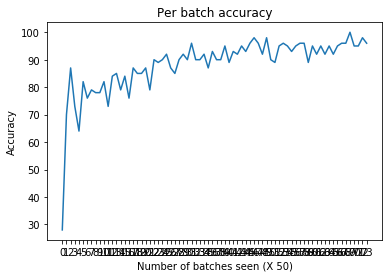

In [55]:
plot_accuracy(per_batch_acc[::50], 'Per batch accuracy', 'Number of batches seen (X 50)')

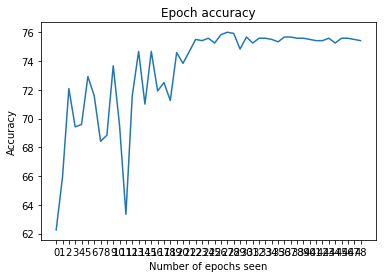

In [56]:
plot_accuracy(epoch_acc, 'Epoch accuracy', 'Number of epochs seen')

### Prediction for challenge

In [57]:
out = model(Variable(torch.from_numpy(test_x)))
_, prediction = torch.max(out, 1)
prediction = prediction.data.numpy()

/home/hristov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(300, 3, 32, 32)
(32, 32, 3)


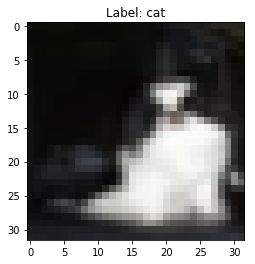

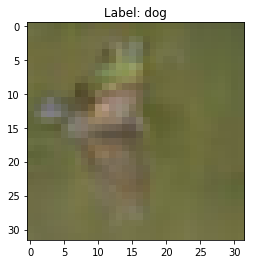

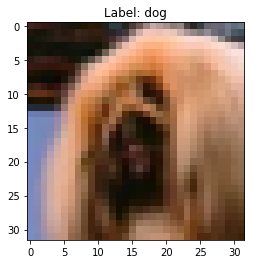

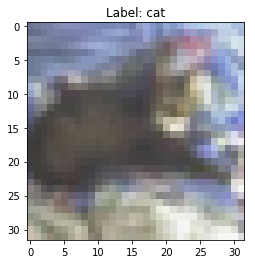

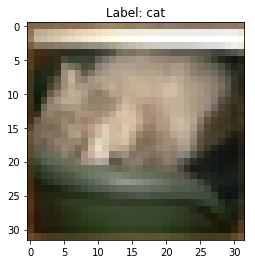

In [58]:
print(test_x.shape)
rolled = np.rollaxis(test_x, 1, 4)
print(rolled[0].shape)

for i in range(5):
    plt.figure()
    plt.imshow(rolled[i] + per_channel_mean)
    plt.title('Label: {}'.format(labels[prediction[i]]))

In [59]:
accuracy = test()[0]
print('Score: {0:.2f}'.format(accuracy))

/home/hristov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set: Average loss: 0.7888, Accuracy: 905/1200 (75.417%)

Score: 75.42


In [60]:
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction_2.npy', prediction)